In [1]:
%load_ext autoreload 
%autoreload 2

from imports import *
import queue_system as qs
from queue_system import *

seed = random.seed(10)
seed_np = np.random.seed(10)

import torch

## Import values

In [2]:
# HERE I CHECK THAT WITH HIGHER NUM MC THE FUNCTION run_simulation CONVERGES. CFR WITH policies_performance9

In [3]:
with open('values/V_agg.pkl', "rb") as fp: 
    V_agg = pickle.load(fp)
with open('values/V_star.pkl', "rb") as fp: 
    V_star = pickle.load(fp)
with open('values/V_opt.pkl', "rb") as fp: 
    V_opt = pickle.load(fp)
with open('values/V_exp.pkl', "rb") as fp: 
    V_exp = pickle.load(fp)

## Import weights

In [4]:
weights_actor_critic = []
n = 0

with open('weights/weights_actor_critic3_' + str(n) + '.pkl', "rb") as fp: #3
    weights_actor_critic.append(pickle.load(fp))

In [5]:
del weights_actor_critic[0]['-1'] 

In [6]:
model = StochasticMatching(graph, arrival_rates, queue_max)

estimated_values = []

for policy in tqdm(weights_actor_critic[0].values()):
    estimated_values.append(model.run_simulation(policy, experts, eta, discount, cLI))

100%|██████████████████████████████████████| 21/21 [41:41:57<00:00, 7148.45s/it]


In [7]:
%%time

rewards_agg_b_expw = []
state_space_tensor = torch.FloatTensor(model.state_space).unsqueeze(0)

        
for policy in tqdm(weights_actor_critic[0].values()):
    
    policy.eval()
        
    with torch.no_grad():
        weights = policy(state_space_tensor).numpy()
   
    P_agg, r_agg = compute_transitions_and_rewards_avg(weights[0])
    V_agg = compute_value_bellman(P_agg, r_agg)
    V_agg_pi0 = 0
    for i in range(len(verteces)):
        state = np.zeros(len(verteces))
        state[i] += 1
        ind = str(val_list.index(tuple(state)))
        V_agg_pi0 += prob_arrival[i] * V_agg[int(ind)]
    rewards_agg_b_expw.append(V_agg_pi0)

100%|███████████████████████████████████████████| 21/21 [00:27<00:00,  1.31s/it]

CPU times: user 43.9 s, sys: 9.41 s, total: 53.3 s
Wall time: 27.6 s


# Final Plot

## average over $\pi_0$

In [8]:
V_star_pi0 = 0
for i in range(len(verteces)):
    state = np.zeros(len(verteces))
    state[i] += 1
    ind = str(val_list.index(tuple(state)))
    V_star_pi0 += prob_arrival[i] * V_star[int(ind)]
    #print(state_space_ind[ind])
    
V_opt_pi0 = 0
for i in range(len(verteces)):
    state = np.zeros(len(verteces))
    state[i] += 1
    ind = str(val_list.index(tuple(state)))
    V_opt_pi0 += prob_arrival[i] * V_opt[int(ind)]
    #print(state_space_ind[ind])

In [9]:
V_exp_pi0 = {str(exp) : 0 for exp in experts}
for v, exp in zip(V_exp, experts):
    for i in range(len(verteces)):
        state = np.zeros(len(verteces))
        state[i] += 1
        ind = str(val_list.index(tuple(state)))
        V_exp_pi0[str(exp)] += prob_arrival[i] * v[int(ind)]
        #print(state_space_ind[ind])

## Plot

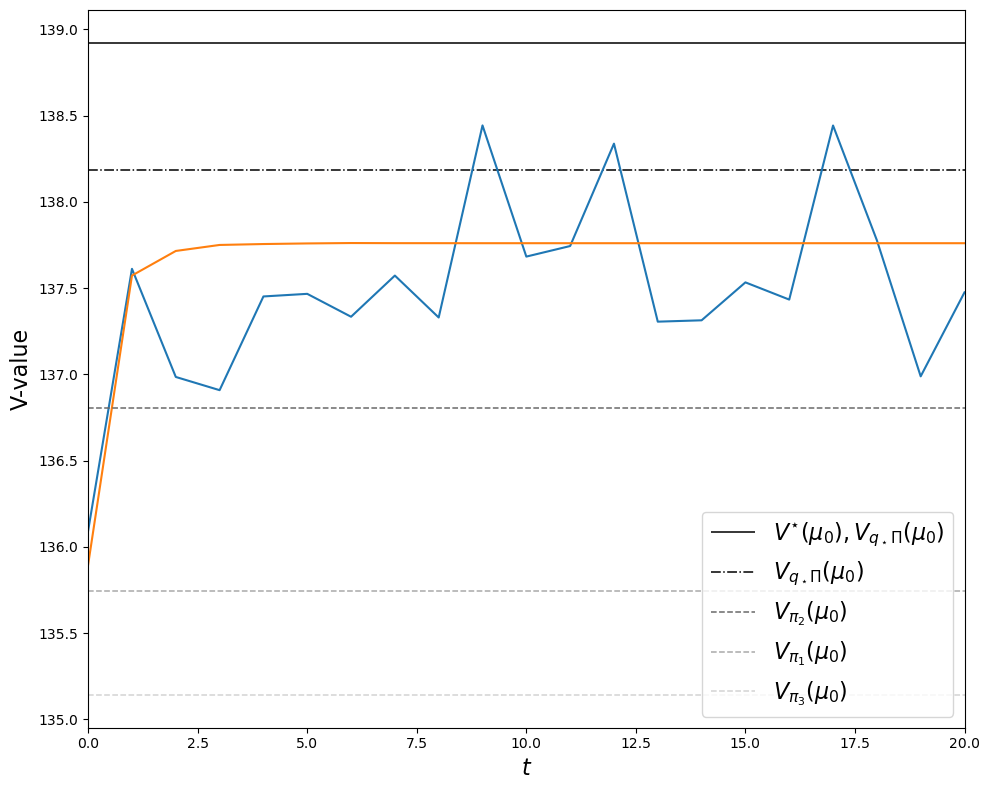

In [10]:
values_list = []

updates_x = np.array(range(82)) * 100 #* 5000
updates_NN = np.array(range(22)) * 100 

figure(figsize=(10, 8))


plt.hlines(V_star_pi0, 0, updates_x[-1], 'black',  linewidth=1.1, label = '$V^{\star}(\mu_0), V_{q_\star\Pi}(\mu_0)$')
plt.hlines(V_opt_pi0, 0, updates_x[-1], 'black', ls ='dashdot',  linewidth=1.1, label = '$V_{q_\star\Pi}(\mu_0)$')

plt.plot(estimated_values)
plt.plot(rewards_agg_b_expw)
        
c = ['dimgrey', 'darkgrey', 'lightgrey', 'grey', 'darkgrey']
count = 0
    
V_exp_sorted = sorted(V_exp_pi0.items(), key=lambda x:x[1], reverse= True)

for item in V_exp_sorted:
    plt.hlines(item[1], 0, updates_x[-1], c[count], linestyle='dashed', linewidth=1.1, label = '$V_{\pi_' + str(exp_ind[item[0]] +1 ) + '}(\mu_0)$')
    count += 1

plt.xlabel('$t$', fontsize=16)
plt.ylabel('V-value', fontsize=16)
plt.xlim((0, 20))
# plt.ylim((1.08, 1.09))
#plt.title('Values comparison')
plt.legend(loc='lower right', fontsize=16)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('figures/policies_performance10.pdf')